In [1]:
from VariationalBayes import ScalarParam, ModelParamsDict, VectorParam, PosDefMatrixParam
from VariationalBayes.NormalParams import UVNParam, UVNParamVector
from VariationalBayes.ExponentialFamilies import UnivariateNormalEntropy, UVNPrior

from autograd import grad, hessian, jacobian, hessian_vector_product
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy as asp
import scipy as sp

import copy
from scipy import optimize

In [60]:
# Load data saved by stan_results_to_json.R and run_stan.R in LRVBLogitGLMM.
import os
import json

simulate_data = False
prior_par = ModelParamsDict('Prior Parameters')

# Simulate data
N = 200     # observations per group
K = 5      # dimension of regressors
NG = 200      # number of groups

# Generate data
NObs = NG * N
true_beta = np.array(range(5))
true_beta = true_beta - np.mean(true_beta)
true_y_info = 1.0

true_mu = 0.0
true_mu_info = 40.0
true_u = np.random.normal(true_mu, 1 / np.sqrt(true_mu_info), NG)

x_mat = np.random.random(K * NObs).reshape(NObs, K) - 0.5
y_g_vec = np.array([ g for g in range(NG) for n in range(N) ])
true_mean = np.matmul(x_mat, true_beta) + true_u[y_g_vec]
print true_mean
y_vec = np.random.normal(true_mean, 1 / np.sqrt(true_y_info), NG * N)

prior_par.push_param(ScalarParam('beta_mean', val=0.0))
prior_par.push_param(ScalarParam('beta_info', val=0.01))

prior_par.push_param(ScalarParam('mu_mean', val=0.))
prior_par.push_param(ScalarParam('mu_info', val=0.5))

prior_par.push_param(ScalarParam('mu_log_info_mean', val=0.))
prior_par.push_param(ScalarParam('mu_log_info_info', val=10.0))

prior_par.push_param(ScalarParam('y_log_info_mean', val=0.0))
prior_par.push_param(ScalarParam('y_log_info_info', val=10.0))

print N * NG

[-1.26660167 -0.8429095   0.62232385 ..., -0.08710899 -0.16869404
  0.01746562]
40000


In [61]:
# Build an object to contain a variational approximation to a K-dimensional multivariate normal.

# ADVI-style, we will represent each parameter as a univariate normal.
# Note: you need to include the Jacobian of the transform because the log prior is not a density
# with respect to the transformed space.
lmm_par = ModelParamsDict('LMM Parameters')

lmm_par.push_param(UVNParamVector('beta', K))
lmm_par.push_param(UVNParam('mu'))
lmm_par.push_param(UVNParam('mu_log_info'))
lmm_par.push_param(UVNParam('y_log_info'))
lmm_par.push_param(UVNParamVector('u', NG))

lmm_par['beta'].mean.set(np.full(K, -0.2))
lmm_par['beta'].info.set(np.full(K, 1.0))

lmm_par['mu'].mean.set(0.2)
lmm_par['mu'].info.set(1.5)

lmm_par['mu_log_info'].mean.set(0.3)
lmm_par['mu_log_info'].info.set(1.1)

lmm_par['y_log_info'].mean.set(0.4)
lmm_par['y_log_info'].info.set(1.1)

lmm_par['u'].mean.set(np.full(NG, -0.1))
lmm_par['u'].info.set(np.full(NG, 0.8))

free_par_vec = lmm_par.get_free()

In [62]:
# A single draw from the variational distribution.
lmm_draw = ModelParamsDict('LMM Parameter draw')

lmm_draw.push_param(VectorParam('beta', K))
lmm_draw.push_param(ScalarParam('mu'))
lmm_draw.push_param(ScalarParam('mu_log_info'))
lmm_draw.push_param(ScalarParam('y_log_info'))
lmm_draw.push_param(VectorParam('u', NG))

def trans_normal_param(draw, par):
    return draw.get() / np.sqrt(par.info.get()) + par.mean.get()

# Set the draw object from the normal parameters in lmm_par by scaling and centering the
# standard normal vector std_normal_vec.
def set_draw(lmm_draw, lmm_par, std_normal_vec):
    lmm_draw.set_vector(std_normal_vec)

    lmm_draw['beta'].set(trans_normal_param(lmm_draw['beta'], lmm_par['beta']))
    lmm_draw['mu'].set(trans_normal_param(lmm_draw['mu'], lmm_par['mu']))
    lmm_draw['mu_log_info'].set(trans_normal_param(lmm_draw['mu_log_info'], lmm_par['mu_log_info']))
    lmm_draw['y_log_info'].set(trans_normal_param(lmm_draw['y_log_info'], lmm_par['y_log_info']))
    lmm_draw['u'].set(trans_normal_param(lmm_draw['u'], lmm_par['u']))

num_draws = 10
std_normal_mat = np.random.normal(size=(num_draws, lmm_draw.vector_size()))
std_normal_vec = std_normal_mat[0, :]
set_draw(lmm_draw, lmm_par, std_normal_vec)

# Sanity check
print np.mean(lmm_draw['u'].get())
print 1 / np.var(lmm_draw['u'].get())


-0.100981173748
0.811362148186


In [63]:
# Define moment parameters
moment_par = ModelParamsDict('Moment Parameters')
moment_par.push_param(VectorParam('e_beta', K))
moment_par.push_param(ScalarParam('e_mu'))
moment_par.push_param(ScalarParam('e_mu_log_info'))
moment_par.push_param(ScalarParam('e_y_log_info'))
moment_par.push_param(VectorParam('e_u', NG))

def set_moments(lmm_par, moment_par):
    moment_par['e_beta'].set(lmm_par['beta'].e())
    moment_par['e_mu'].set(lmm_par['mu'].e())
    moment_par['e_mu_log_info'].set(lmm_par['mu_log_info'].e())
    moment_par['e_y_log_info'].set(lmm_par['y_log_info'].e())
    moment_par['e_u'].set(lmm_par['u'].e())
    
set_moments(lmm_par, moment_par)

# Moment indices.
moment_indices = copy.deepcopy(moment_par)
moment_indices.set_vector(1 + np.array(range(moment_indices.vector_size())))

In [64]:
def normal_log_prior(draw, prior_mean, prior_info):
    return -0.5 * prior_info * np.sum((draw - prior_mean) ** 2)

def LogPriorDraw(lmm_draw, prior_par):
    return \
        normal_log_prior(lmm_draw['beta'].get(),
                         prior_par['beta_mean'].get(),
                         prior_par['beta_info'].get()) + \
        normal_log_prior(lmm_draw['mu'].get(),
                         prior_par['mu_mean'].get(),
                         prior_par['mu_info'].get()) + \
        normal_log_prior(lmm_draw['mu_log_info'].get(),
                         prior_par['mu_log_info_mean'].get(),
                         prior_par['mu_log_info_info'].get()) + \
        normal_log_prior(lmm_draw['y_log_info'].get(),
                         prior_par['y_log_info_mean'].get(),
                         prior_par['y_log_info_info'].get())

LogPriorDraw(lmm_draw, prior_par)

-3.0429294323498111

In [8]:
def DataLogLikelihoodDraw(x_mat, y_vec, y_g_vec, draw):
    # TODO: this could be way faster by cacheing certain matrix calculations.  See notes.
    y_centered = y_vec - (np.matmul(x_mat, draw['beta'].get()) + draw['u'].get()[y_g_vec])
    y_log_info = draw['y_log_info'].get()[0]
    return -0.5 * np.exp(y_log_info) * np.dot(y_centered, y_centered) + 0.5 * len(y_vec) * y_log_info
    
DataLogLikelihoodDraw(x_mat, y_vec, y_g_vec, lmm_draw)

-55236.76558814798

In [10]:
def RandomEffectLogLikelihoodDraw(draw):
    u_center = draw['u'].get() - draw['mu'].get()
    mu_log_info = draw['mu_log_info'].get()[0]
    return -0.5 * np.exp(mu_log_info) * np.dot(u_center, u_center) + 0.5 * len(u_center) * mu_log_info

RandomEffectLogLikelihoodDraw(lmm_draw)

-166.37661526265069

In [88]:
class DataCache(object):
    def __init__(self, x_mat, y_vec, y_g_vec):
        self.x_mat = x_mat
        self.y_vec = y_vec
        self.y_g_vec = y_g_vec
        self.y_t_y = np.dot(np.transpose(y_vec), y_vec)
        self.y_t_x = np.dot(np.transpose(y_vec), x_mat)
        self.x_t_x = np.dot(np.transpose(x_mat), x_mat)
        
        num_g = np.max(y_g_vec)
        k = x_mat.shape[1]
        num_g = np.max(y_g_vec) + 1
        self.num_g = num_g
        self.n_g = np.full(num_g, 0.0)
        self.y_sum_g = np.full(num_g, 0.0)
        self.x_sum_g = np.full((num_g, k), 0.0)
        for g in range(num_g):
            g_rows = np.array(y_g_vec) == g
            self.n_g[g] = np.sum(g_rows)
            self.y_sum_g[g] = np.sum(y_vec[g_rows])
            self.x_sum_g[g, :] = np.sum(x_mat[g_rows, :], 0)
    
data_cache = DataCache(x_mat, y_vec, y_g_vec)


def DataCacheLogLikelihoodDraw(data_cache, draw):
    beta = draw['beta'].get()
    
    ll_global_term = \
        data_cache.y_t_y + \
        -2 * np.matmul(data_cache.y_t_x, beta) + \
        np.dot(beta, np.matmul(data_cache.x_t_x, beta)) 

    u = draw['u'].get()
#     ll_group_term = 0.0
#     # TODO: this loop seems to make autodiff slow.
#     for g in range(data_cache.num_g):
#         u_g = u[g]
#         ll_group_term += (u_g**2) * data_cache.n_g[g]
#         ll_group_term += -2 * u_g * data_cache.y_sum_g[g]
#         ll_group_term += 2 * u_g * np.dot(data_cache.x_sum_g[g, :], beta)

    ll_group_term = np.sum(
        u**2 * data_cache.n_g[g] + \
        -2 * u * data_cache.y_sum_g + \
        2 * u * np.matmul(data_cache.x_sum_g, beta))

    y_log_info = draw['y_log_info'].get()[0]
    return -0.5 * np.exp(y_log_info) * (ll_global_term + ll_group_term) + 0.5 * len(y_vec) * y_log_info

# These should be equal.
print DataCacheLogLikelihoodDraw(data_cache, lmm_draw)
print DataLogLikelihoodDraw(x_mat, y_vec, y_g_vec, lmm_draw)

-51709.5166493
-51709.5166493


In [89]:
def ELBODataTerm(data_cache, lmm_draw, prior_par):
    ll_data = DataCacheLogLikelihoodDraw(data_cache, lmm_draw)
    if np.isnan(ll_data):
        print 'bad data log likelihood'
        return -np.inf

    ll_rf = RandomEffectLogLikelihoodDraw(lmm_draw)
    if np.isnan(ll_rf):
        print 'bad random effect log likelihood'
        return -np.inf

    e_log_prior = LogPriorDraw(lmm_draw, prior_par)
    if np.isnan(e_log_prior):
        print 'bad prior'
        return -np.inf

    return ll_data + ll_rf + e_log_prior

def ELBOEntropyTerm(lmm_par):
    return UnivariateNormalEntropy(lmm_par['beta'].info.get()) + \
           UnivariateNormalEntropy(lmm_par['mu'].info.get()) + \
           UnivariateNormalEntropy(lmm_par['u'].info.get()) + \
           UnivariateNormalEntropy(lmm_par['y_log_info'].info.get()) + \
           UnivariateNormalEntropy(lmm_par['mu_log_info'].info.get())

def ELBO(data_cache, lmm_par, lmm_draw, prior_par, std_normal_mat):
    entropy = ELBOEntropyTerm(lmm_par)
    
    data_term = 0.0
    num_draws = std_normal_mat.shape[0]
    for draw in range(num_draws):
        set_draw(lmm_draw, lmm_par, std_normal_mat[draw, :])
        data_term += ELBODataTerm(data_cache, lmm_draw, prior_par)

    data_term /= num_draws
    
    return data_term + entropy
        
class KLWrapper(object):
    def __init__(self, lmm_par, lmm_draw, prior_par, x_mat, y_vec, y_g_vec, num_draws):
        self.__lmm_par_ad = copy.deepcopy(lmm_par)
        self.__prior_par_ad = copy.deepcopy(prior_par)
        self.__lmm_draw_ad = copy.deepcopy(lmm_draw)
        self.__data_cache = DataCache(x_mat, y_vec, y_g_vec)
        self.randomize(num_draws)

    def randomize(self, num_draws):
        self.std_normal_mat = np.random.normal(size=(num_draws, self.__lmm_draw_ad.vector_size()))
        
    def KL(self, free_par_vec, verbose=False):
        self.__lmm_par_ad.set_free(free_par_vec)
        #print self.__lmm_par_ad
        kl = -ELBO(self.__data_cache,
                   self.__lmm_par_ad,
                   self.__lmm_draw_ad,
                   self.__prior_par_ad,
                   self.std_normal_mat)
        if verbose: print kl

        return kl
        

class MomentWrapper(object):
    def __init__(self, lmm_par, moment_par):
        self.__lmm_par_ad = copy.deepcopy(lmm_par)
        self.__moment_par = copy.deepcopy(moment_par)

    # Return a posterior moment of interest as a function of unconstrained parameters.
    def GetMoments(self, free_par_vec):
        self.__lmm_par_ad.set_free(free_par_vec)
        set_moments(self.__lmm_par_ad, self.__moment_par)
        return self.__moment_par.get_vector()
    
    def GetMomentParameters(self, free_par_vec):
        self.__glmm_par_ad.set_free(free_par_vec)
        set_moments(self.__glmm_par_ad, self.__moment_par)
        return self.__moment_par


kl_wrapper = KLWrapper(lmm_par, lmm_draw, prior_par, x_mat, y_vec, y_g_vec, 20)
KLGrad = grad(kl_wrapper.KL)
KLHess = hessian(kl_wrapper.KL)
KLHessVecProd = hessian_vector_product(kl_wrapper.KL)  
print kl_wrapper.KL(free_par_vec)

moment_wrapper = MomentWrapper(lmm_par, moment_par)
MomentJacobian = jacobian(moment_wrapper.GetMoments)


88182.278858


In [90]:
import timeit

kl_wrapper.randomize(10)

time_num = 10

print 'Function time:'
print timeit.timeit(lambda: kl_wrapper.KL(free_par_vec), number=time_num) / time_num

print 'Grad time:'
print timeit.timeit(lambda: KLGrad(free_par_vec), number=time_num) / time_num

print 'Hessian vector product time:'
print timeit.timeit(lambda: KLHessVecProd(free_par_vec, free_par_vec + 1), number=time_num) / time_num

# print 'Moment jacobian time:'
# print timeit.timeit(lambda: MomentJacobian(free_par_vec), number=time_num) / time_num

# time_num = 1
# print 'Prior Hessian time:'
# print timeit.timeit(lambda: PriorHess(combined_free_par_vec), number=time_num) / time_num

# so slow
# print 'Hessian time:'
# print timeit.timeit(lambda: KLHess(free_par_vec), number=time_num) / time_num


Function time:
0.00268239974976
Grad time:
0.0297542095184
Hessian vector product time:
0.0682099819183


In [91]:
import time

kl_wrapper.randomize(30)

class OptimizationPath(object):
    def __init__(self):
        self.x_history = []
        pass
    
    def save(self, x):
        self.x_history.append(x)

bfgs_path = OptimizationPath()
init_par_vec = copy.deepcopy(free_par_vec)

# Optimize.
vb_time = time.time()

# print 'Running BFGS'
# vb_opt_bfgs = optimize.minimize(
#     lambda par: kl_wrapper.KL(par, verbose=True), init_par_vec,
#     method='bfgs', jac=KLGrad, tol=1e-2, callback=bfgs_path.save,
#     options={'maxiter': 100, 'gtol': 1e-2, 'disp': True})

kl_wrapper.randomize(5)

trust_path = OptimizationPath()
print 'Running Newton Trust Region'
# trust_init = copy.deepcopy(vb_opt_bfgs.x)
trust_init = copy.deepcopy(init_par_vec)
vb_opt_1 = optimize.minimize(
    lambda par: kl_wrapper.KL(par, verbose=True),
    trust_init, method='trust-ncg', jac=KLGrad, hessp=KLHessVecProd,
    tol=1e-6, callback=trust_path.save, options={'maxiter': 100, 'disp': True, 'gtol': 1e-6 })

kl_wrapper.randomize(30)

trust_path = OptimizationPath()
print 'Running Newton Trust Region'
# trust_init = copy.deepcopy(vb_opt_bfgs.x)
trust_init = copy.deepcopy(init_par_vec)
vb_opt = optimize.minimize(
    lambda par: kl_wrapper.KL(par, verbose=True),
    vb_opt_1.x, method='trust-ncg', jac=KLGrad, hessp=KLHessVecProd,
    tol=1e-6, callback=trust_path.save, options={'maxiter': 100, 'disp': True, 'gtol': 1e-6 })

vb_time = time.time() - vb_time

lmm_par_opt = copy.deepcopy(lmm_par)
lmm_par_opt.set_free(vb_opt.x)

print 'Done.'

print vb_time / 60

Running Newton Trust Region
96652.3284297
56407.6340521
47373.2734274
42887.1548731
39750.5861539
37771.9778996
33699.2687606
32385.6956622
27700.5968208
27454.3771177
23782.7111455
23371.3736891
22485.9149486
22457.7065733
21817.2949974
20884.2459014
20828.9519129
20689.0479343
20628.929425
20178.7893983
20176.0312593
20174.2034437
20168.4309441
20061.6868945
20061.5484542
20060.70238
20045.6260404
20045.6158316
20045.5849025
20044.996034
20044.9960092
20044.9959206
20044.9944941
20044.9944937
20044.9944937
Optimization terminated successfully.
         Current function value: 20044.994494
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
         Hessian evaluations: 0
Running Newton Trust Region
20258.7191564
20202.2351099
20187.6894418
20181.6648727
20162.6523743
20150.1661371
20121.7185989
20118.6179089
20101.5478164
20101.4551201
20099.0548802
20099.0547593
20098.9193877
20098.9109958
20098.910988
20098.910988
20098.910988
Optimization te

--------------- beta:

[-2. -1.  0.  1.  2.]
[-2.02930518 -1.00411966  0.01169808  1.00481703  2.00168907]
--------------- mu:

0.00126079142866
0.0
--------------- mu log info:

3.29481465947
3.68887945411
--------------- y log info:

-0.000716924715438
0.0


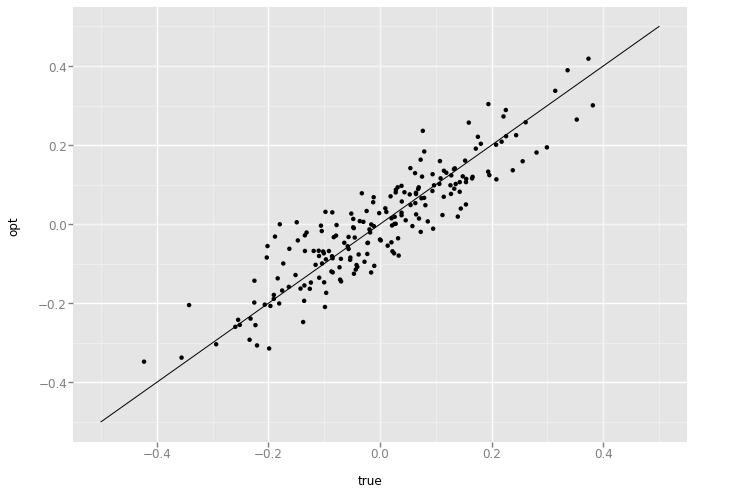

<ggplot: (8741306617981)>


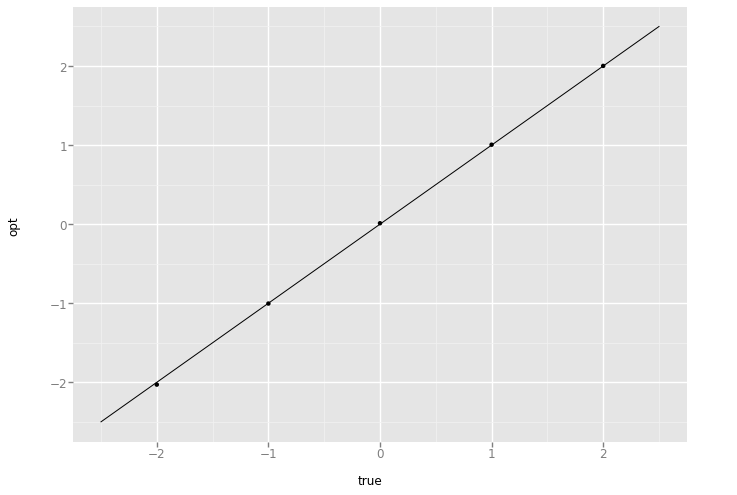

<ggplot: (8741306827257)>


In [92]:
# print(glmm_par_opt)
print '--------------- beta:\n'
print true_beta
print lmm_par_opt['beta'].e()

print '--------------- mu:\n'
print lmm_par_opt['mu'].e()[0]
print true_mu

print '--------------- mu log info:\n'
print lmm_par_opt['mu_log_info'].e()[0]
print np.log(true_mu_info)

print '--------------- y log info:\n'
print lmm_par_opt['y_log_info'].e()[0]
print np.log(true_y_info)


# Check the random effect estimates.  This requires simulated data.
from ggplot import *
import pandas as pd
%matplotlib inline

e_u = lmm_par_opt['u'].e()

plot_df = pd.DataFrame({ 'opt': lmm_par_opt['u'].e(), 'true': true_u })
print ggplot(plot_df, aes(x='true', y='opt')) + geom_point() + geom_abline(slope=1, intercept=0)

plot_df = pd.DataFrame({ 'opt': lmm_par_opt['beta'].e(), 'true': true_beta })
print ggplot(plot_df, aes(x='true', y='opt')) + geom_point() + geom_abline(slope=1, intercept=0)


In [95]:
# Slow, but probably faster than using CG if you want the covariance of many parameters.
hess_time = time.time()
print 'Calculating KL Hessian.\n'
kl_hess = KLHess(vb_opt.x)
hess_time =  time.time() - hess_time
elbo_hess = -kl_hess
print 'Done.\n'

print 'hess_time: %f' % hess_time

Calculating KL Hessian.

Done.

496273336.875
hess_time: 54.143301


In [105]:
hess_norm = np.sqrt(np.sum(kl_hess**2))
diag_norm = np.sqrt(np.sum(np.diag(kl_hess)**2))

# How diagonal is the Hessian?
print hess_norm 
print (hess_norm - diag_norm) / hess_norm

22277.1932001
0.000350886396672


In [94]:
moment_jac = MomentJacobian(vb_opt.x)
lrvb_cov = np.matmul(moment_jac, np.linalg.solve(kl_hess, moment_jac.T))

prior_indices = copy.deepcopy(prior_par)
prior_indices.set_vector(1 + np.array(range(prior_indices.vector_size())))

vp_indices = copy.deepcopy(lmm_par_opt)
vp_indices.set_vector(1 + np.array(range(vp_indices.vector_size())))